# Importar librerias

In [12]:
import torch
print(torch.cuda.is_available())  # True
print(torch.cuda.get_device_name(0))  # NVIDIA GeForce RTX 3050

True
NVIDIA GeForce RTX 3050 Laptop GPU


In [13]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import os, math, random, pathlib
from typing import Tuple
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms as T

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Dimensionar las imagenes

In [17]:
from torchvision import transforms

# Transformaciones para entrenamiento (aumentos + normalización)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0,
                            translate=(0.05, 0.05)),  # equivalente a width/height_shift
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# Transformaciones para validación y test (solo reescalado + normalización)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# Inicio del codigo

In [18]:
# ----------------- Config -----------------
BASE_DIR   = "002_cancer"
TRAIN_DIR  = os.path.join(BASE_DIR, "train")
VAL_DIR    = os.path.join(BASE_DIR, "val")
TEST_DIR   = os.path.join(BASE_DIR, "test")

CLASSES = 2
BATCH   = 32
ROWS = COLS = 224
INPUT_CH = 3
SEED         = 42
EPOCHS       = 15
TEST_MAX_SAMPLES = 3000

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
torch.manual_seed(SEED)


Using device: cuda


In [19]:
# ===== Datasets & Dataloaders =====
from torch.utils.data import random_split

# Comprobación de carpetas
for p in [TRAIN_DIR, TEST_DIR]:
    assert os.path.isdir(os.path.join(p, "Benign")),    f"Falta {p}/Benign"
    assert os.path.isdir(os.path.join(p, "Malignant")), f"Falta {p}/Malignant"

use_explicit_val = os.path.isdir(VAL_DIR) and all(
    os.path.isdir(os.path.join(VAL_DIR, c)) for c in ["Benign", "Malignant"]
)

if use_explicit_val:
    train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
    val_ds   = datasets.ImageFolder(VAL_DIR,   transform=val_test_transforms)
else:
    # Split desde TRAIN -> (train, val)
    full_train = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
    val_ratio  = 0.2
    n_total    = len(full_train)
    n_val      = int(n_total * val_ratio)
    n_train    = n_total - n_val
    train_ds, val_ds = random_split(
        full_train, [n_train, n_val],
        generator=torch.Generator().manual_seed(SEED)
    )

test_ds  = datasets.ImageFolder(TEST_DIR, transform=val_test_transforms)

NUM_WORKERS = 0 if os.name == "nt" else 4
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=(device=="cuda"))
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(device=="cuda"))
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(device=="cuda"))

# Mapeo de clases
if use_explicit_val:
    class_to_idx = datasets.ImageFolder(TRAIN_DIR).class_to_idx
else:
    class_to_idx = train_ds.dataset.class_to_idx if hasattr(train_ds, "dataset") else datasets.ImageFolder(TRAIN_DIR).class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}
print("Clases:", class_to_idx)
print(f"Train={len(train_ds)} | Val={len(val_ds)} | Test={len(test_ds)}")


Clases: {'Benign': 0, 'Malignant': 1}
Train=9504 | Val=2375 | Test=2000


In [20]:
# ===== Modelo básico (CNN pequeña) =====
import torch.nn as nn
import torch.nn.functional as F

class BasicCNN(nn.Module):
    def __init__(self, in_ch=3, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, 32, kernel_size=3, padding=1),  # [B,32,224,224]
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                                  # [B,32,112,112]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),      # [B,64,112,112]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                                  # [B,64,56,56]

            nn.Conv2d(64, 128, kernel_size=3, padding=1),     # [B,128,56,56]
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                                  # [B,128,28,28]

            nn.Conv2d(128, 256, kernel_size=3, padding=1),    # [B,256,28,28]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                                  # [B,256,14,14]
        )
        self.pool = nn.AdaptiveAvgPool2d((1,1))               # [B,256,1,1]
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

model = BasicCNN(in_ch=INPUT_CH, num_classes=CLASSES).to(device)
print(model)


BasicCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, aff

In [21]:
# ===== Entrenamiento =====
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

# Bandera para AMP: True solo si hay GPU
USE_AMP = (device == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

best_val_loss = float("inf")
best_path = "basic_cnn_best.pt"
patience = 5
epochs_no_improve = 0

def run_epoch(loader, train_mode=True):
    if train_mode:
        model.train()
    else:
        model.eval()
    total, correct, running = 0, 0, 0.0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)

        if USE_AMP:
            with torch.cuda.amp.autocast():
                logits = model(xb)
                loss   = criterion(logits, yb)
        else:
            logits = model(xb)
            loss   = criterion(logits, yb)

        if train_mode:
            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

        running += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        total += yb.size(0)
        correct += (pred == yb).sum().item()

    return running/total, correct/total


C:\Users\Usuario\AppData\Local\Temp\ipykernel_20572\772398189.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


In [22]:
# Historial para gráficas
hist = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss":   [],
    "val_acc":    []
}

In [23]:
# ===== Loop de entrenamiento con early stopping =====
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train_mode=True)

    # valida sólo cada 2 épocas (o la final)
    do_val = (epoch % 2 == 0) or (epoch == EPOCHS)
    if do_val:
        with torch.no_grad():
            va_loss, va_acc = run_epoch(val_loader, train_mode=False)
        scheduler.step(va_loss)

        # --- guardar historial ---
        hist["epoch"].append(epoch)
        hist["train_loss"].append(tr_loss)
        hist["train_acc"].append(tr_acc)
        hist["val_loss"].append(va_loss)
        hist["val_acc"].append(va_acc)

        print(f"[{epoch:02d}/{EPOCHS}] "
              f"train_loss={tr_loss:.4f} acc={tr_acc:.3f} | "
              f"val_loss={va_loss:.4f} acc={va_acc:.3f} | "
              f"LR={optimizer.param_groups[0]['lr']:.6f}",
              flush=True)

        # early stopping con mejor val_loss
        if va_loss < best_val_loss - 1e-4:
            best_val_loss = va_loss
            epochs_no_improve = 0
            torch.save({"model": model.state_dict(), "class_to_idx": class_to_idx}, best_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

    else:
        # Épocas sin validación: también guardamos train_* para que queden en el gráfico
        hist["epoch"].append(epoch)
        hist["train_loss"].append(tr_loss)
        hist["train_acc"].append(tr_acc)
        hist["val_loss"].append(None)  # sin validación esta época
        hist["val_acc"].append(None)

        print(f"[{epoch:02d}/{EPOCHS}] "
              f"train_loss={tr_loss:.4f} acc={tr_acc:.3f} | "
              f"LR={optimizer.param_groups[0]['lr']:.6f}",
              flush=True)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_20572\772398189.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[01/15] train_loss=0.4479 acc=0.785 | LR=0.001000
[02/15] train_loss=0.4064 acc=0.812 | val_loss=0.3770 acc=0.834 | LR=0.001000
[03/15] train_loss=0.3744 acc=0.829 | LR=0.001000
[04/15] train_loss=0.3463 acc=0.843 | val_loss=0.3361 acc=0.848 | LR=0.001000
[05/15] train_loss=0.3427 acc=0.842 | LR=0.001000
[06/15] train_loss=0.3383 acc=0.850 | val_loss=0.3172 acc=0.865 | LR=0.001000
[07/15] train_loss=0.3284 acc=0.853 | LR=0.001000
[08/15] train_loss=0.3172 acc=0.860 | val_loss=0.3102 acc=0.871 | LR=0.001000
[09/15] train_loss=0.3095 acc=0.863 | LR=0.001000
[10/15] train_loss=0.3134 acc=0.862 | val_loss=0.2957 acc=0.878 | LR=0.001000
[11/15] train_loss=0.3077 acc=0.869 | LR=0.001000
[12/15] train_loss=0.3099 acc=0.862 | val_loss=0.2979 acc=0.872 | LR=0.001000
[13/15] train_loss=0.3103 acc=0.866 | LR=0.001000
[14/15] train_loss=0.2980 acc=0.870 | val_loss=0.3160 acc=0.864 | LR=0.001000
[15/15] train_loss=0.2941 acc=0.873 | val_loss=0.2980 acc=0.884 | LR=0.000500


In [24]:
# ===== Recargar mejor modelo =====
ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model"])     # restaurar pesos
class_to_idx = ckpt["class_to_idx"]      # restaurar mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Mejor modelo cargado desde:", best_path)

Mejor modelo cargado desde: basic_cnn_best.pt


C:\Users\Usuario\AppData\Local\Temp\ipykernel_20572\209376415.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path, map_location=device)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_20572\2385917512.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path, map_location=device)


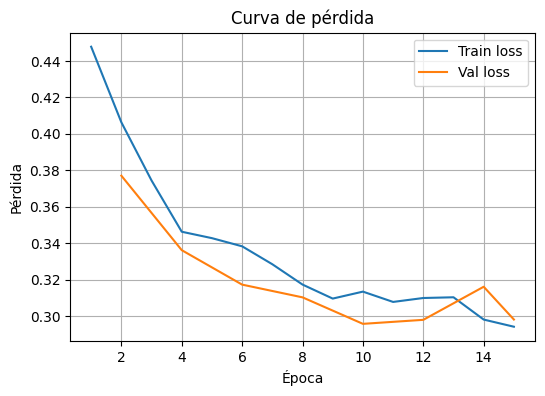

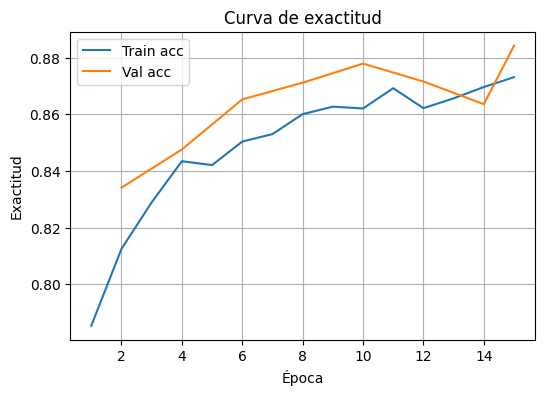

In [25]:
# (Asegúrate de haber recargado el mejor checkpoint)
ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model"])
class_to_idx = ckpt["class_to_idx"]
idx_to_class = {v:k for k,v in class_to_idx.items()}

# --- Graficar curvas ---
import matplotlib.pyplot as plt
import numpy as np

epochs = np.array(hist["epoch"])
tr_loss = np.array(hist["train_loss"], dtype=float)
tr_acc  = np.array(hist["train_acc"], dtype=float)
# Para val, algunas épocas pueden ser None si no validaste: filtramos
val_mask = np.array([v is not None for v in hist["val_loss"]], dtype=bool)
val_epochs = epochs[val_mask]
val_loss   = np.array([v for v in hist["val_loss"] if v is not None], dtype=float)
val_acc    = np.array([v for v in hist["val_acc"]  if v is not None], dtype=float)

plt.figure(figsize=(6,4))
plt.plot(epochs, tr_loss, label="Train loss")
if val_mask.any():
    plt.plot(val_epochs, val_loss, label="Val loss")
plt.xlabel("Época"); plt.ylabel("Pérdida")
plt.title("Curva de pérdida")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, tr_acc, label="Train acc")
if val_mask.any():
    plt.plot(val_epochs, val_acc, label="Val acc")
plt.xlabel("Época"); plt.ylabel("Exactitud")
plt.title("Curva de exactitud")
plt.legend()
plt.grid(True)
plt.show()


C:\Users\Usuario\AppData\Local\Temp\ipykernel_20572\2285277376.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Test accuracy: 0.8645
              precision    recall  f1-score   support

      Benign       0.82      0.93      0.87      1000
   Malignant       0.92      0.80      0.86      1000

    accuracy                           0.86      2000
   macro avg       0.87      0.86      0.86      2000
weighted avg       0.87      0.86      0.86      2000



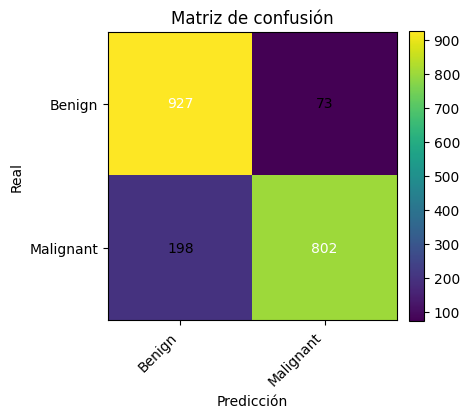

In [26]:
# pip install scikit-learn
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        if USE_AMP:
            with torch.cuda.amp.autocast():
                logits = model(xb)
        else:
            logits = model(xb)
        pred = logits.argmax(1).cpu()
        all_preds.append(pred)
        all_labels.append(yb)

all_preds  = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

test_acc = (all_preds == all_labels).mean()
print(f"Test accuracy: {test_acc:.4f}")
print(classification_report(all_labels, all_preds,
                            target_names=[idx_to_class[0], idx_to_class[1]]))

# --- Matriz de confusión (plot) ---
cm = confusion_matrix(all_labels, all_preds, labels=[0,1])

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(4.8,4.8))
im = plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de confusión")
plt.colorbar(im, fraction=0.046, pad=0.04)
tick_marks = np.arange(2)
plt.xticks(tick_marks, [idx_to_class[0], idx_to_class[1]], rotation=45, ha="right")
plt.yticks(tick_marks, [idx_to_class[0], idx_to_class[1]])
plt.xlabel("Predicción")
plt.ylabel("Real")

# anotar los valores en cada celda
th = cm.max() / 2.0 if cm.size > 0 else 0.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"),
                 ha="center", va="center",
                 color="white" if cm[i, j] > th else "black")

plt.tight_layout()
plt.show()
